# Interactive generation of graphene moiré lattices
Author: [Tobias A. de Jong](https://github.com/TAdeJong)

This notebook uses `numpy`, `dask` and `matplotlib` to easily generate moiré lattices of two hexagonal graphene lattices. Using `ipywidgets`, we create an interactive plot where the angle can be adopted.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import ipywidgets as widgets

import dask.array as da

from latticegen import hexlattice_gen, hexlattice_gen_fast
from dask.distributed import Client, LocalCluster

import colorcet as cc

In [2]:
# Create a dask cluster for parallel computation. Settings optimized to play nice with mybinder.org
cluster = LocalCluster(n_workers=1, threads_per_worker=4, memory_limit='2GB')  
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:41191 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 1 Cores: 4 Memory: 2.00 GB


In [3]:
S = 500  # Size of visualization in pixels. Optimized for interactive rendering on mybinder.
r_k = 0.2 
a_0 = 0.246  # Lattice constant of graphene in nm

xi0 = 15

## A single lattice

First, let's look at a single hexagonal lattice and compare what the `order` parameter, the maximum order of the Fourier/k-vector components does: The higher the order, the more well-resolved the atoms are as single spots. However, computational complexity increases fast.

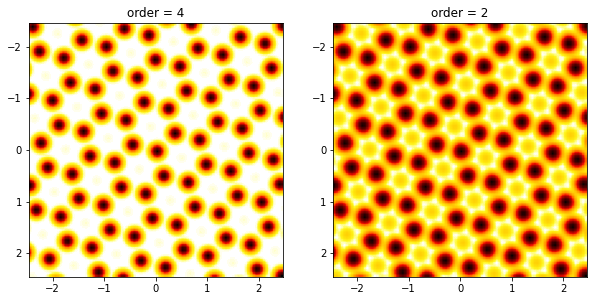

In [4]:
fig, ax = plt.subplots(figsize=[10,5], ncols=2)
edge = r_k*a_0/2
extent = np.array([-edge, edge, edge, -edge])
ax[0].imshow(hexlattice_gen(r_k/3, xi0, 4, 100).T.compute(), 
             cmap='cet_fire_r',
            extent=100*extent)
ax[0].set_title('order = 4')
ax[1].imshow(hexlattice_gen(r_k/3, xi0, 2, 100).T.compute(), 
             cmap='cet_fire_r',
            extent=100*extent)
ax[1].set_title('order = 2');

## A moiré superlattice of two lattices

Now, we can visualize what the moiré of two stacked lattices looks like and play around with the influence of deforming the top lattice.
We by default drop back to `order=2` to keep things snappy, (and use the fastmath implementation).

In [6]:
# Dropping back to order=2 for computational reasons
iterated0 = 0.7*hexlattice_gen_fast(r_k, xi0, 2, S).persist()


def plot(theta=1.05, kappa=1., psi=0., xi=0.):
    """Make a plot of a two stacked lattices, where the top lattice 
    is rotated by theta degrees, and stretched by kappa in 
    the direction psi degrees from the x-axis.
    The total stack is rotated by 'xi' degrees.
    Significantly slower for xi != xinot, as this prohibits the cached lattice to be used.
    """
    fig, ax = plt.subplots(figsize=[10,10])
    if xi != xi0:
        iterated1 = 0.7*hexlattice_gen_fast(r_k, xi, 2, S)
    else:
        iterated1 = iterated0

    iterated2 = hexlattice_gen_fast(r_k, theta+xi, 2, S, kappa=kappa, psi=psi)
    data = (iterated1 + iterated2).compute()
    im = ax.imshow(data.T, cmap='cet_fire_r', extent=S*extent, 
                   vmax=np.quantile(data,0.9),
                   vmin=np.quantile(data,0.1),
                  )
    ax.set_xlabel('x (nm)')
    ax.set_ylabel('y (nm)')
    ax.set_title(f'$\\theta = {theta:.2f}^\\circ, \\kappa = {kappa:.3f}, \\psi = {psi:.2f}^\\circ$')

widgets.interactive(plot, 
                    theta=widgets.FloatSlider(value=1.05, min=0, max=5,step=0.05, 
                                              continuous_update=False, description='twist  $\\theta$'),
                    kappa=widgets.FloatSlider(value=1.005, min=1, max=1.1,step=0.005, 
                                              continuous_update=False, readout_format='.3f', 
                                              description='strain $\\kappa$'),
                    psi=widgets.FloatSlider(value=0, min=-90, max=90,step=5, 
                                            continuous_update=False, readout_format='.0f', 
                                            description='strain angle $\\psi$'),
                    xi=widgets.FloatSlider(value=xi0, min=-90, max=90,step=5, 
                                           continuous_update=False, readout_format='.0f', 
                                           description='substrate angle $\\xi$'),
   )

interactive(children=(FloatSlider(value=1.05, continuous_update=False, description='twist  $\\theta$', max=5.0…